In [1]:
import pandas as pd
import numpy as np
import re
import math
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import porter
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import psycopg2 as pc
from IPython import display
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import csv
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\krist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing articles

In [3]:
#Reading the data from 1mio-raw.csv
dataTotal = pd.read_csv('250t-raw.csv')

#We will only analyse a smaller part of the data set
data = dataTotal


C:\Users\krist\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
SQL_database_login = "dbname=datascience user=postgres password=2419"
SQLtables_path = "/Users/krist/Desktop/Uni/milestone/DataScienceRep01/final_project/SQLtables/"

## Function Definitions

In [3]:
#cleantext cleans the input string with the following functions: Characters are set to lowercase, 
#urls are substituted with <URL>, dates are substitured with <DATE>, emails are substitured with <EMAIL>
#numbers are substitured with <NUM>, newlines and non-letter characters are removed.
def cleantext(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'<|>', "", text)
    text = re.sub(r'(https?:\/\/)?w{0,3}\.?[a-z]+\.[a-z]\w*[\w\/-]*', "<URL>", text)
    text = re.sub(r'(jan\.?(uary)?|feb\.?(uary)?|mar\.?(ch)?|apr\.?(il)?|may|jun\.(e)?|jul\.(y)?|aug\.?(ust)?|sep\.?(tember)?|oct\.?(ober)?|nov\.?(ember)?|dec\.?(ember)?|monday|tuesday|wednesday|thursday|friday|saturday|sunday) (the )?\d{1,2}((th)?,?( \d{4})?)?', "<DATE>", text)
    text = re.sub(r'\w+@\w+\.[a-zA-Z]{2,3}', "<EMAIL>", text)
    text = re.sub(r'[0-9]+', "<NUM>", text)
    text = re.sub(r'(\\n)+|\s{2,}|(\\t+)', " ", text)
    text = re.sub(r'\.|,|\\|-|\?|\(|\)|\||&|"|”|“|:|!|\+|-|–|—|\/|\$|%|€|#|;|\[|\]|©|®|…|=', "", text)
    return text

#cleanMetaKeywords cleans the input string with the following functions: 
#Characters are set to lowercase, newlines and non-letter characters are removed.
def cleanMetaKeywords(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'(\\n)+|\s{2,}|(\\t+)', " ", text)
    text = re.sub(r'\.|\\|-|\?|\(|\)|\||&|"|”|“|:|!|\+|-|\'|–|—|\/|\$|%|€|#|;|\[|\]|©|®|…|=|<|>', "", text)
    return text

def tokenize(text):
    return word_tokenize(text)

def stopword(word_list):
    stop_words = stopwords.words('english')
    
    return [word for word in word_list if word not in stop_words]

def stemming(word_list):
    stemmer = porter.PorterStemmer()

    return [stemmer.stem(word) for word in word_list]

def getSoup(url):
    response = requests.get(url)
    contents = response.content
    return BeautifulSoup(contents, 'html.parser')

def executeSQL(filename, cur):
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()
    sqlCommands = sqlFile.split(';')
    for command in sqlCommands:
            cur.execute(command)



## Scraping data from Politics and Conflict

In [ ]:
group_nr = 1
article_start_letters = "ABCDEFGHIJKLMNOPRSTUVWZABCDEFGHIJKLMNOPRSTUVWZ"[group_nr%23:group_nr%23+10]
print(article_start_letters)

In [ ]:
#The algorithm stops finding new articles when 'stop_searching' is set to True
stop_searching = False

#Finding the nextpage link in the first iteration is a little different, and therefore this value is needed
first_iteration = True

#The root url is the domain of wikinews
root_link = 'https://en.wikinews.org'

#next_page is the webpage that the algorithm searches for articles in next iteration of the while-loop
next_page = root_link + '/w/index.php?title=Category:Politics_and_conflicts'

#The links to the articles starting with the 'article_start_letters' are appended to 'article links'
article_links = []

#For each iteration this list gets some values if the first letter 
#of the first article in the next webpage is between A and K
first_letter_between_B_K = []

#A regex used for 'first_letter_between_B_K'
continue_iterations = re.compile(r"pagefrom=[A-K]")

In [ ]:
while not(stop_searching):
    soup = getSoup(next_page)
    articles = soup.find(id="mw-pages")
    
    links = [link.get("href") for link in articles.find_all('a')]
    
    if first_iteration:
        first_letter_between_B_K = continue_iterations.findall(links[0])
        first_iteration = False
        next_page = root_link + links[0]
        article_links += [root_link + group_link for group_link in links[1:] if group_link[6] in article_start_letters]
    else:
        first_letter_between_B_K = continue_iterations.findall(links[1])
        next_page = root_link + links[1]
        article_links += [root_link + group_link for group_link in links[2:] if group_link[6] in article_start_letters]
    
    if len(first_letter_between_B_K) == 0:
        stop_searching = True
    
    first_letter_between_B_K = []

In [ ]:
article_source_code = [getSoup(article) for article in article_links]

In [ ]:
#These id's has to be different from the other articles
article_id = range(len(data),len(data)+len(article_links))
article_titles = [article.find('h1').get_text() for article in article_source_code]
article_release_date = [str(article.find(id="publishDate"))[50:60] for article in article_source_code]
article_urls = article_links
article_content = [" ".join([p.get_text() for p in (article.find(id="mw-content-text")).find_all('p')]) for article in article_source_code]

In [ ]:
scraped_articles = pd.DataFrame()

scraped_articles['id'] = article_id
scraped_articles['content'] = [cleantext(content) for content in article_content]
scraped_articles['title'] = article_titles
scraped_articles['release_date'] = article_release_date
scraped_articles['url'] = article_urls

scraped_articles

In [ ]:
scraped_articles.to_csv("SQLtables/scraped_articles.csv",index=False,header=False)

In [4]:
#Setting up a connection with the SQL server. Make sure that you write your own dbname, user and password as input
conn = pc.connect(SQL_database_login)
cur = conn.cursor()

In [ ]:
executeSQL('SQLfiles/createTableScraped.sql', cur)

## Cleaning data and creating SQL database

In [7]:
#Remove duplicate articles and NaN content-values
data = data.drop_duplicates(subset="content")
data = data.dropna(subset=["content"])

In [8]:
#Cleaning the content
cleaned_content = [cleantext(article_content) for article_content in data['content']]

#Cleaning meta keywords
clean_meta_keywords = [cleanMetaKeywords(metakeyword) for metakeyword in data["meta_keywords"]]

In [9]:
#Making sure that each element of 'tags', 'authors' and 'meta_keywords' are stripped stings and converting them to arrays
data["tags"] = [[tag.strip() for tag in (str(i)).split(",")] for i in data["tags"]]
data["authors"] = [[author.strip() for author in (str(i)).split(",")] for i in data["authors"]]
data["meta_keywords"] = [[meta_keyword.strip() for meta_keyword in (str(i)).split(",")] for i in clean_meta_keywords]
data["content"] = cleaned_content
data["id"] = range(0,len(data))

In [10]:
#Entity tables
articles = data[['id','content','url','meta_description','title']]

meta_keywords = pd.DataFrame((data[['meta_keywords']].explode('meta_keywords')).drop_duplicates(subset = 'meta_keywords'))
meta_keywords = meta_keywords.rename(columns={0: 'meta_keywords'})
meta_keywords["ide"] = range(0,len(meta_keywords))
article_meta_keywords = pd.merge(meta_keywords, data[['id','meta_keywords']].explode('meta_keywords'), on = "meta_keywords")[['id','ide']]
article_meta_keywords = article_meta_keywords.rename(columns={'id': 'article_id', 'ide': 'meta_keyword_id'})

domains = pd.DataFrame((data['domain']).drop_duplicates())
domains = domains.rename(columns={0: 'domain'})
domains["ide"] = range(0,len(domains))
owns = pd.merge(domains, data, on = "domain")[['id','ide']]
owns = owns.rename(columns={'id': 'article_id', 'ide': 'domain_id'})

authors = pd.DataFrame((data[['authors']].explode('authors')).drop_duplicates())
authors = authors.rename(columns={0: 'authors'})
authors["ide"] = range(0,len(authors))
article_authors = pd.merge(authors, data[['id','authors']].explode('authors'), on = "authors")[['id','ide']]
article_authors = article_authors.rename(columns={'id': 'article_id', 'ide': 'author_id'})

types = pd.DataFrame((data['type']).drop_duplicates())
types = types.rename(columns={0: 'type'})
types["ide"] = range(0,len(types))
article_types = pd.merge(types, data, on = "type")[['id','ide']]
article_types = article_types.rename(columns={'id': 'article_id', 'ide': 'type_id'})

In [11]:
#Entities to CSV
articles.to_csv("SQLtables/articles.csv",index=False,header=False)
meta_keywords.to_csv("SQLtables/meta_keywords.csv",index=False,header=False)
authors.to_csv("SQLtables/authors.csv",index=False,header=False)
domains.to_csv("SQLtables/domains.csv",index=False,header=False)
types.to_csv("SQLtables/types.csv",index=False,header=False)

#Relations to CSV
owns.to_csv("SQLtables/owns.csv",index=False,header=False)
article_authors.to_csv("SQLtables/article_authors.csv",index=False,header=False)
article_meta_keywords.to_csv("SQLtables/article_meta_keywords.csv",index=False,header=False)
article_types.to_csv("SQLtables/article_types.csv",index=False,header=False)

In [12]:
#executeSQL('SQLfiles/createTables.sql', cur)
#executeSQL('SQLfiles/setUpTables.sql', cur)
cur.execute("BEGIN TRANSACTION;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article(id integer, content text COLLATE pg_catalog.\"default\", url text COLLATE pg_catalog.\"default\", meta_description text COLLATE pg_catalog.\"default\", title text COLLATE pg_catalog.\"default\") WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article_meta_keywords(article_id integer, meta_keyword_id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.authors(name text COLLATE pg_catalog.\"default\", id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.authors_of(article_id integer, author_id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.domain(name text COLLATE pg_catalog.\"default\", id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.meta_keywords(meta_keyword text COLLATE pg_catalog.\"default\", id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.owns(article_id integer, domain_id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.types(type text COLLATE pg_catalog.\"default\", id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("CREATE TABLE IF NOT EXISTS public.article_types(article_id integer, type_id integer) WITH (OIDS = FALSE) TABLESPACE pg_default;")
cur.execute("COMMIT TRANSACTION;")

In [13]:
cur.execute("BEGIN TRANSACTION;")
cur.execute("delete from article *; copy article from '" + SQLtables_path + "articles.csv' with (format csv);")
cur.execute("delete from authors *; copy authors from '" + SQLtables_path + "authors.csv' with (format csv);")
cur.execute("delete from authors_of *; copy authors_of from '" + SQLtables_path + "article_authors.csv' with (format csv);")
cur.execute("delete from owns *; copy owns from '" + SQLtables_path + "owns.csv' with (format csv);")
cur.execute("delete from meta_keywords *; copy meta_keywords from '" + SQLtables_path + "meta_keywords.csv' with (format csv);")
cur.execute("delete from domain *; copy domain from '" + SQLtables_path + "domains.csv' with (format csv);")
cur.execute("delete from article_meta_keywords *; copy article_meta_keywords from '" + SQLtables_path + "article_meta_keywords.csv' with (format csv);")
cur.execute("delete from types *; copy types from '" + SQLtables_path + "types.csv' with (format csv);")
cur.execute("delete from article_types *; copy article_types from '" + SQLtables_path + "article_types.csv' with (format csv);")
cur.execute("COMMIT TRANSACTION;")

## Uploading data from database and creating REAL/FAKE labels

In [5]:
#dataframe
cur.execute("""select a.id, a.content, t.type
            from article as a, article_types as at, types as t 
            where a.id = at.article_id and t.id = at.type_id""")
SQL_articles1 = pd.DataFrame(cur.fetchall())
SQL_articles1.columns = ['id', 'content', 'type']
SQL_articles1



,id,content,type
0,0,life is an illusion at least on a quantum leve...,rumor
1,1,the los angeles police department has been den...,hate
2,2,the white house has decided to quietly withdra...,hate
3,10,if you don’t believe in fate here’s a story th...,satire
4,11,lost words hidden words otters banks and books...,fake
...,...,...,...
178218,32975,manhattan is a place where millions of people ...,political
178219,32976,the main reason i hate the supreme court's ove...,political
178220,32977,notable christian and unnotable quarterback ti...,political
178221,32978,remember a year ago when the world was simpler...,political


In [9]:
SQL_articles = SQL_articles1
SQL_articles = SQL_articles[~SQL_articles['type'].isin(['unreliable','junksci','rumor', 'hate','unknown'])] #removes these types
SQL_articles = SQL_articles.dropna(subset = ['type']) #drops where type is nan
SQL_articles.loc[SQL_articles['type'].isin(['fake','satire','bias', 'conspiracy']), 'label'] = 'Fake' #labels types 'fake'
SQL_articles.loc[SQL_articles['type'].isin(['reliable','political','clickbait']), 'label'] = 'True' #labels types 'true'
SQL_articles = SQL_articles.sample(n=22000, random_state= 22)
SQL_articles

137393


,id,content,type,label
135667,135238,google billionaires james cameron backing spac...,fake,Fake
118417,118387,first just when american's who can't pay atten...,political,True
129373,129157,gospel of thomas being spiritually reborn head...,fake,Fake
1106,1130,world world news and events china the middle e...,conspiracy,Fake
164460,164461,for more news visit ☛ <URL>com follow us on tw...,fake,Fake
...,...,...,...,...
66637,65972,christopher matthews reports for time <DATE> t...,conspiracy,Fake
131866,131545,permanent makeup leaves ladies looking boston ...,fake,Fake
80347,79963,many articles concerned with the energy crisis...,political,True
117406,117359,yes our little texan has returned home no sma...,political,True


## Establishing a baseline 

In [10]:
vect = TfidfVectorizer()
content_tfidf = vect.fit_transform(SQL_articles['content'])
content_tfidf_df = pd.DataFrame(content_tfidf.todense(),columns = vect.get_feature_names())


In [11]:
X_train, X_test, y_train, y_test = train_test_split(content_tfidf, SQL_articles['label'], test_size=0.40, random_state=42)

In [12]:
# Define the classifier classes
k_nearest = KNeighborsClassifier(n_neighbors=15, weights='distance')

# Fit the model
k_nearest.fit(X_train,y_train)

# Predict on the test set
k_nearest_pred = k_nearest.predict(X_test)

# Evaluate performance
print("k_nearest accuracy:" + str(accuracy_score(y_test,k_nearest_pred)))


k_nearest accuracy:0.6748863636363637


In [15]:
# Define the classifier classes
random_f = RandomForestClassifier(max_depth=50)

# Fit the model
random_f.fit(X_train,y_train)

# Predict on the test set
random_f_pred = random_f.predict(X_test)

# Evaluate performance
print("random_f accuracy:" + str(accuracy_score(y_test, random_f_pred)))

random_f accuracy:0.7785


## Fake News predictor 

In [ ]:
#Tokenizer and model input
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

#Tokenize input
tokenized = SQL_articles['content'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
model.eval()

#Pad input so that all sequences are of the same size:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
padded = padded[:,:256]

# Tell embedding model to disregard pad tokens
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
device = torch.device("cpu")

if torch.cuda.is_available():
  model = model.cuda()
  device = torch.device("cuda")

# Convert input to a pytorch tensor
input = torch.tensor(np.array(padded), device=device)
attention_mask = torch.tensor(attention_mask, device=device)

# Embed sequences (processing in batches to avoid memory problems)
batch_size= 200
embeddings = []

for start_index in range(0, input.shape[0], batch_size):
  with torch.no_grad():
    # Call embedding model
    embedding = model(input[start_index:start_index+batch_size], 
                      attention_mask=attention_mask[start_index:start_index+batch_size])[0][:,0,:]
    embeddings.append(embedding)
embeddings = torch.cat(embeddings)   # concatenate all batch outputs back into one tensor

# Move embeddings back to numpy
embeddings = embeddings.cpu().numpy()

The best hidden_layer_sizes is: (15, 15, 15, 15, 15, 15)
[[0.77733333]]


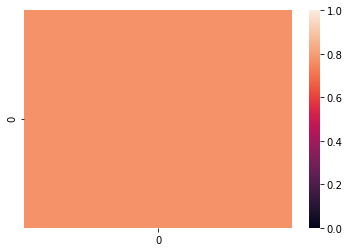

In [18]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, SQL_articles['label'])

In [ ]:
layers = [3,4]
layer_sizes = [5,10,15]
tuple_list = []

for layer_size in layer_sizes:
    for layer in layers:
        tuple_list.append((layer_size,)*layer)
        
inputs = {'hidden_layer_sizes': tuple_list}

# Define the classifier classes
MLP = MLPClassifier()

#Gridsearch
cross_val = GridSearchCV(MLP, inputs)

# Fit the model
cross_val.fit(X_train, y_train)

In [ ]:
df = pd.DataFrame(cross_val.cv_results_)

In [ ]:
hidden_layers = np.zeros((len(layer_sizes),len(layers)))
mts = df['mean_test_score']
best_parameters = df['param_hidden_layer_sizes'][np.argmax(np.array(mts))]
print("The best hidden_layer_sizes is: " + str(best_parameters))

for i in range(len(layer_sizes)):
    for j in range(len(layers)):
        hidden_layers[i,j] = mts[j+i*len(layers)]
        

sns.heatmap(hidden_layers, vmin = 0.0, vmax = 1.0)
print(hidden_layers)

## Kaggle competition

In [24]:
KAGGLE_df = pd.read_json(r'\Users\krist\Desktop\Uni\milestone\DataScienceRep01\final_project\test_set.json')
#Cleaning the kaggle_content
KAGGLE_df['article'] = [cleantext(article_content) for article_content in KAGGLE_df['article']]  


content_tfidf = vect.transform(KAGGLE_df['article'])

#Following line is the actual prediction based on the previously trained model 'cross_val'
KAGGLE_df_prediction = cross_val.predict(content_tfidf)

print((KAGGLE_df_prediction))

to_kaggle_df = KAGGLE_df[['id','article']]
to_kaggle_df['article'] = KAGGLE_df_prediction
to_kaggle_df = to_kaggle_df.rename(columns={'article':'label'})
to_kaggle_df.loc[to_kaggle_df['label'].isin([1]), 'label'] = 'REAL' #labels types 'fake'
to_kaggle_df.loc[to_kaggle_df['label'].isin([0]), 'label'] = 'FAKE' #labels types 'true'
#articles = articles.rename(columns={0:'id',1:'content',2:'type'})
print(to_kaggle_df)
to_kaggle_df.to_csv("Kaggle_prediction.csv",index=False)

['True' 'True' 'Fake' ... 'Fake' 'True' 'True']
         id label
0      8476  True
1     10294  True
2      3608  Fake
3     10142  True
4       875  True
...     ...   ...
6330   4490  True
6331   8062  True
6332   8622  Fake
6333   4021  True
6334   4330  True

[6335 rows x 2 columns]
